## VGG Like Deep Classifier

Il notebook addestra un classificatore utilizzando una rete neurale profonda la cui architettura è simile a VGG-16.

---

[Karen Simonyan, Andrew Zisserman - VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION](https://arxiv.org/pdf/1409.1556.pdf)

[Neurohive - VGG-16 overview](https://neurohive.io/en/popular-networks/vgg16/)

[@jhan15 - Facial Emotion Recognition](https://github.com/jhan15/facial_emotion_recognition)


### Import

In [ ]:
import os
from zipfile import ZipFile
from google.colab import drive

import cv2

from matplotlib import pyplot as plt

import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.test import gpu_device_name

### Setup

In [ ]:
def check_gpu():
    device_name = gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

if True:
    check_gpu()

Found GPU at: /device:GPU:0


In [ ]:
drive.mount('/content/dario')

with ZipFile(os.path.join(os.getcwd(), 'dario/MyDrive/vp/dataset.zip'), 'r') as zip_file:
    zip_file.extractall('data')

Mounted at /content/dario


### Configurazione

In [ ]:
# classes = ['happy', 'sad']
classes = ['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral', 'surprise']
labels = [i for i in range(len(classes))]
class_dict = dict(zip(labels, classes))

train_dir = 'data/train/'
max_examples = None

random_state = 42

### Caricamento dei dati

In [ ]:
examples = list()

for (label, path) in class_dict.items():
    current_dir = os.path.join(os.getcwd(), train_dir, path)
    i = 0
    for image_path in os.listdir(current_dir):
        if max_examples != None and i > max_examples:
            break
        image = cv2.cvtColor(cv2.imread(os.path.join(current_dir, image_path)), cv2.COLOR_BGR2GRAY)
        examples.append((image, label))
        i += 1

### Visualizzazione dei dati

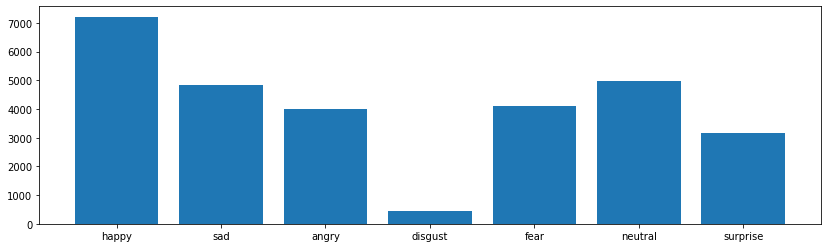

In [ ]:
example_stats = dict()

for example in examples:
    current_class = class_dict[example[1]]
    if not current_class in example_stats:
        example_stats[current_class] = 0
    example_stats[current_class] += 1

plt.figure(figsize=(2 * len(example_stats.items()), 4))
plt.bar(example_stats.keys(), example_stats.values())
plt.show()

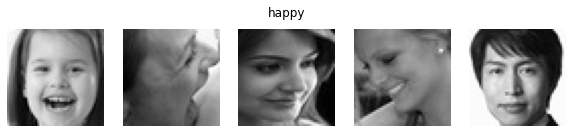

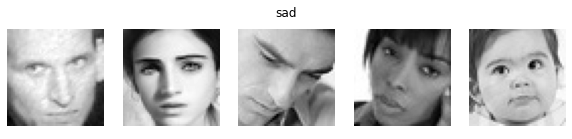

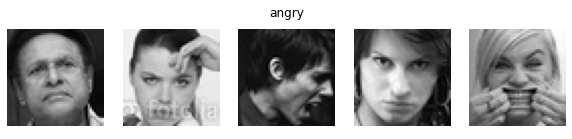

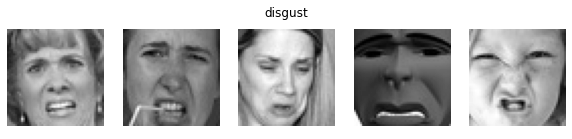

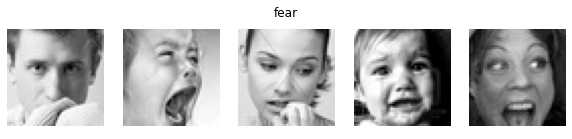

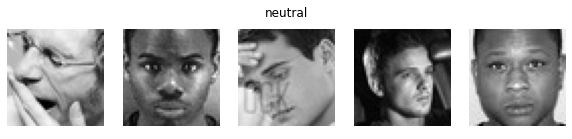

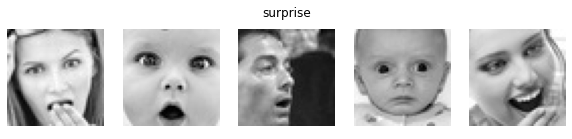

In [ ]:
previous_examples_amount = 0

for current_class in class_dict.items():
    figure = plt.figure(figsize=(10, 2))
    plt.title(current_class[1])
    plt.axis('off')

    n_examples = 5
    previous_examples_amount += example_stats[class_dict[current_class[0] - 1]] if current_class[0] > 0 else 0
    axes = figure.subplots(1, n_examples)
    for i in range(n_examples):
        axes[i].axis('off')
        axes[i].imshow(examples[i + previous_examples_amount][0], cmap='gray')

    plt.show()

### Modello

In [ ]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Flatten())
        
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(256, activation='relu'))

        self.add(Dense(num_classes, activation='softmax'))

### Train, validation, test split

In [ ]:
X = []
y = []

for example in examples:
    X.append(example[0])
    y.append(example[1])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = np.reshape(X_train, (-1, 48, 48, 1))
X_test = np.reshape(X_test, (-1, 48, 48, 1))
X_val = np.reshape(X_val, (-1, 48, 48, 1))

### Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.1,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 128
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = X_train[0].shape

### Addestramento

In [ ]:
model = VGGNet(input_shape, len(classes))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "vgg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                           

In [ ]:
n_epochs = 150

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-10)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        validation_data=val_generator,
        callbacks=[lr, es])

Epoch 1/150
120/120 [==============================] - 24s 107ms/step - loss: 2.1327 - accuracy: 0.2098 - val_loss: 1.8748 - val_accuracy: 0.2121 - lr: 0.0010
Epoch 2/150
120/120 [==============================] - 11s 95ms/step - loss: 1.8262 - accuracy: 0.2385 - val_loss: 1.7710 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 3/150
120/120 [==============================] - 12s 96ms/step - loss: 1.7901 - accuracy: 0.2537 - val_loss: 1.7514 - val_accuracy: 0.2719 - lr: 0.0010
Epoch 4/150
120/120 [==============================] - 12s 103ms/step - loss: 1.7314 - accuracy: 0.2902 - val_loss: 1.6651 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 5/150
120/120 [==============================] - 11s 95ms/step - loss: 1.6822 - accuracy: 0.3214 - val_loss: 1.7749 - val_accuracy: 0.3322 - lr: 0.0010
Epoch 6/150
120/120 [==============================] - 12s 95ms/step - loss: 1.6119 - accuracy: 0.3578 - val_loss: 1.5575 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 7/150
120/120 [=============================

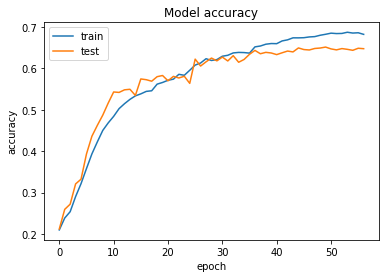

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

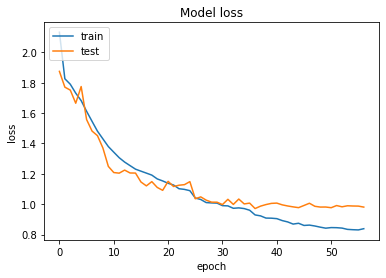

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

297/297 [==============================] - 3s 8ms/step


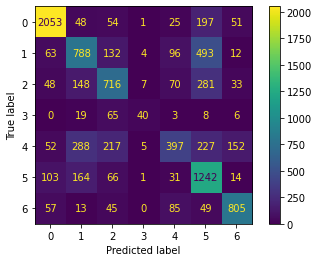

              precision    recall  f1-score   support

       happy       0.86      0.85      0.85      2429
         sad       0.54      0.50      0.52      1588
       angry       0.55      0.55      0.55      1303
     disgust       0.69      0.28      0.40       141
        fear       0.56      0.30      0.39      1338
     neutral       0.50      0.77      0.60      1621
    surprise       0.75      0.76      0.76      1054

    accuracy                           0.64      9474
   macro avg       0.64      0.57      0.58      9474
weighted avg       0.65      0.64      0.63      9474



In [ ]:
predictions = model.predict(X_test)
y_predicted = list(map(lambda p: np.argmax(p), predictions))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predicted))
disp.plot()
plt.show()

print(classification_report(y_test, y_predicted, target_names=classes))

### Salvataggio modello

In [ ]:
model.save('vgg-like')

%cp 'vgg-like' 'dario/MyDrive/vp' -r